In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 

df_transaction = pd.read_csv("transactions_dataset.csv",sep=";").sample(5000000)

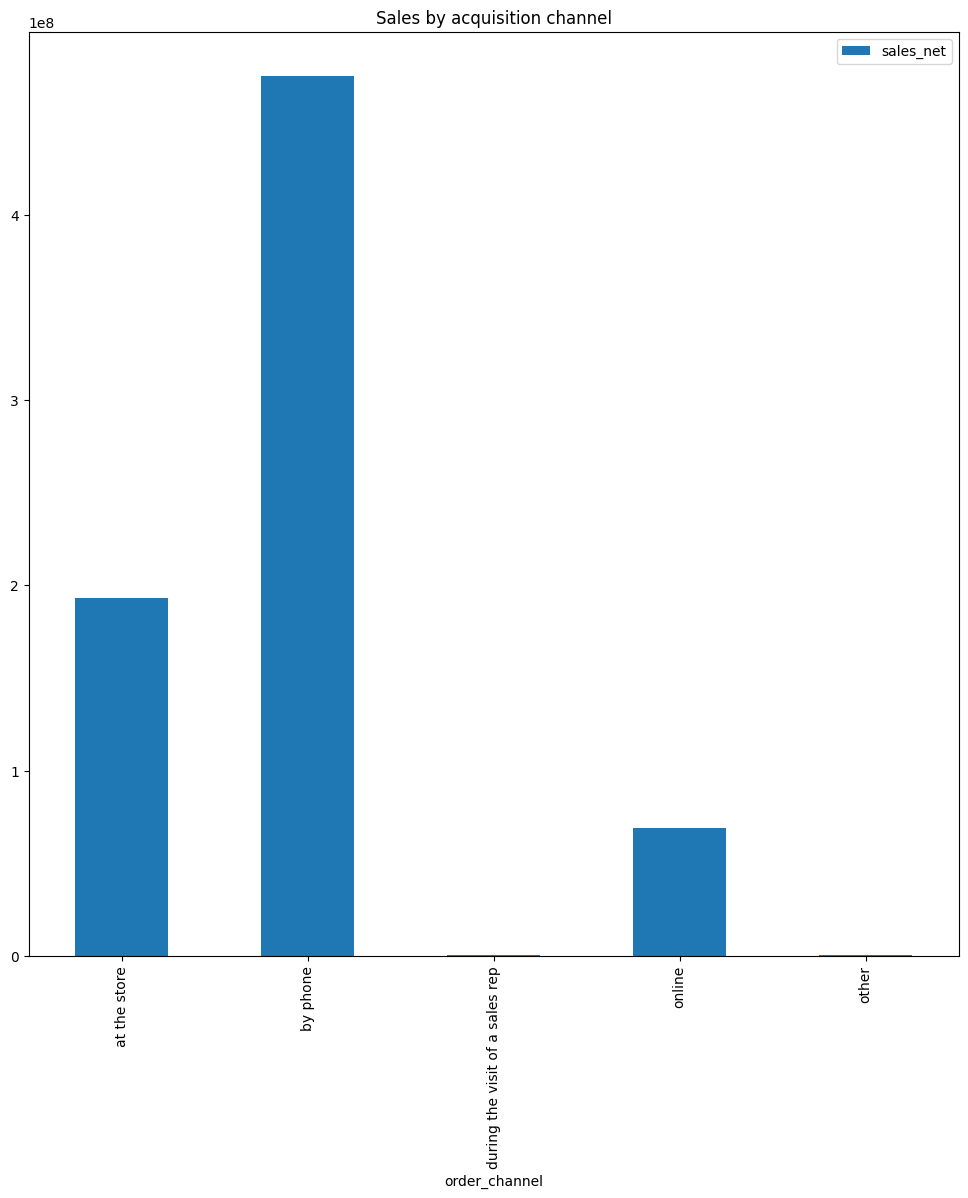

In [2]:
#Analyse des données

ax = pd.DataFrame(df_transaction.groupby("order_channel").sales_net.sum()).plot(kind="bar",figsize=(12,12),title="Sales by acquisition channel")
plt.show();

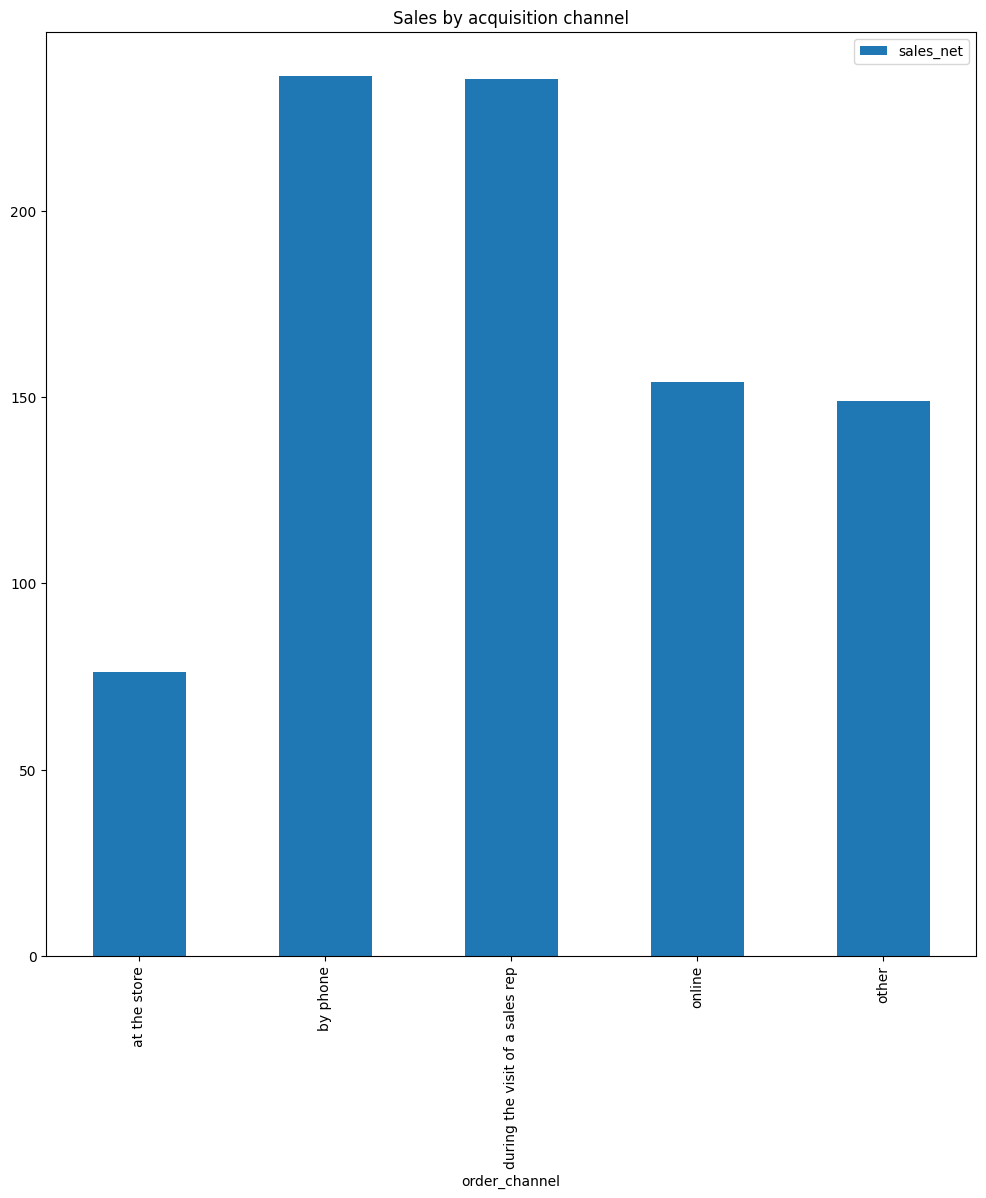

In [3]:
ax = pd.DataFrame(df_transaction.groupby("order_channel").sales_net.mean()).plot(kind="bar",figsize=(12,12),title="Sales by acquisition channel")
plt.show();

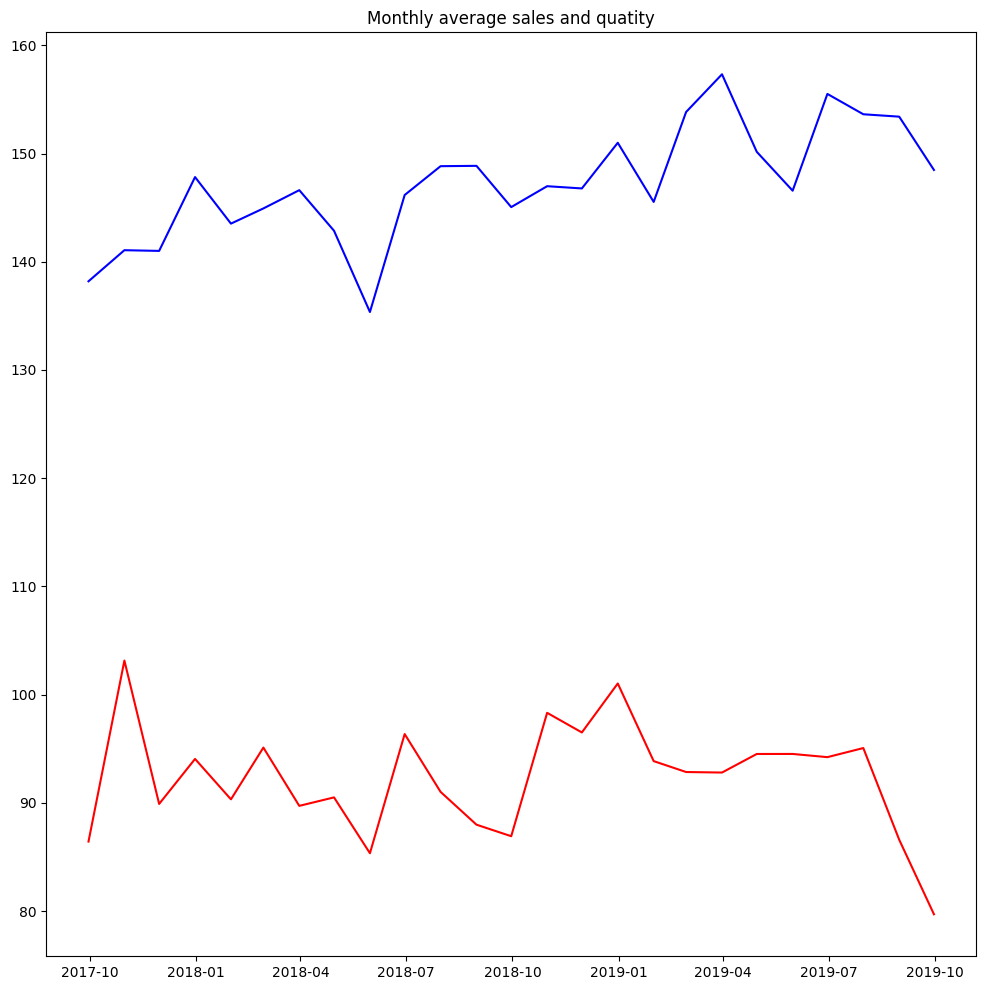

In [4]:
df_transaction["date_order"] = pd.to_datetime(df_transaction["date_order"])
plt.figure(figsize=(12,12))
plt.title("Monthly average sales and quatity",fontsize=12)
plt.plot(df_transaction.set_index("date_order").resample("M").mean()["quantity"],color="red",label="Quantity")
plt.plot(df_transaction.set_index("date_order").resample("M").mean()["sales_net"],color="blue",label="Total sales")
plt.show();

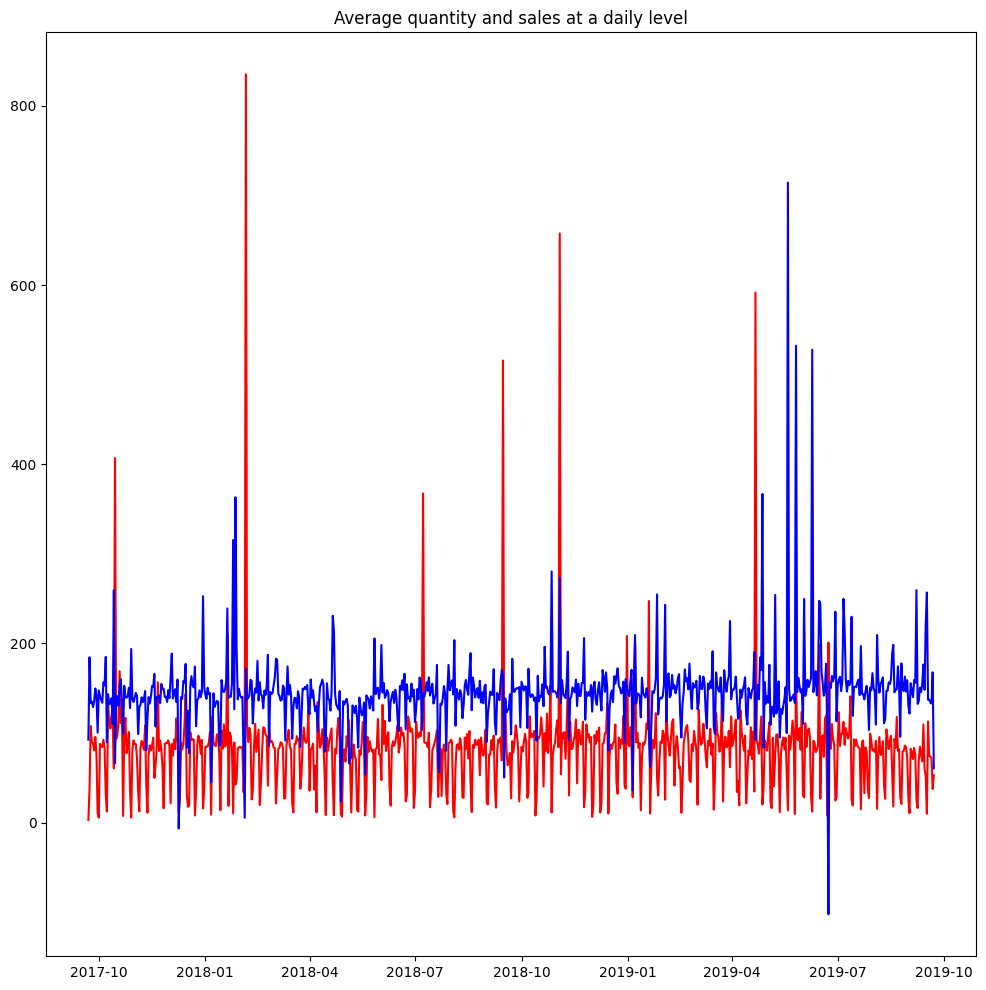

In [5]:
df_transaction["date_order"] = pd.to_datetime(df_transaction["date_order"])
plt.figure(figsize=(12,12))
plt.title("Average quantity and sales at a daily level")
plt.plot(df_transaction.set_index("date_order").resample("D").mean()["quantity"],color="red",label="quanity")
plt.plot(df_transaction.set_index("date_order").resample("D").mean()["sales_net"],color="blue",label="sales")
plt.show();

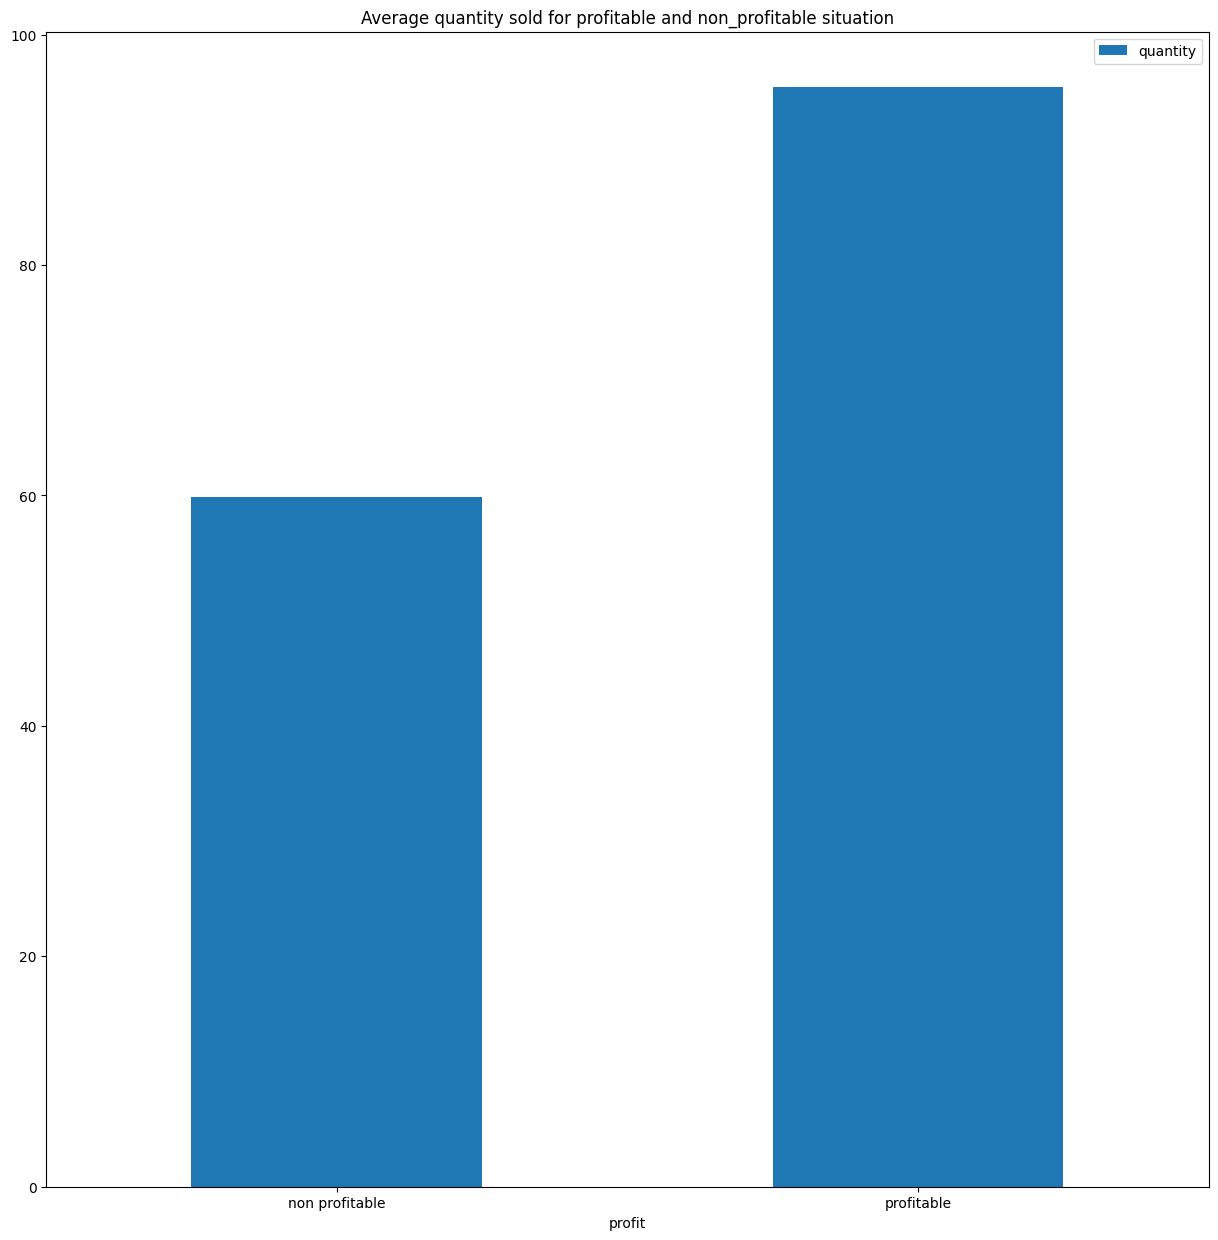

In [6]:
df_transaction["profit"] = df_transaction["sales_net"].apply(lambda x: "profitable" if x>0 else "non profitable")

pd.DataFrame(df_transaction.groupby("profit").quantity.mean()).plot(kind="bar",title="Average quantity sold for profitable and non_profitable situation",rot=360,figsize=(15,15))
plt.show();

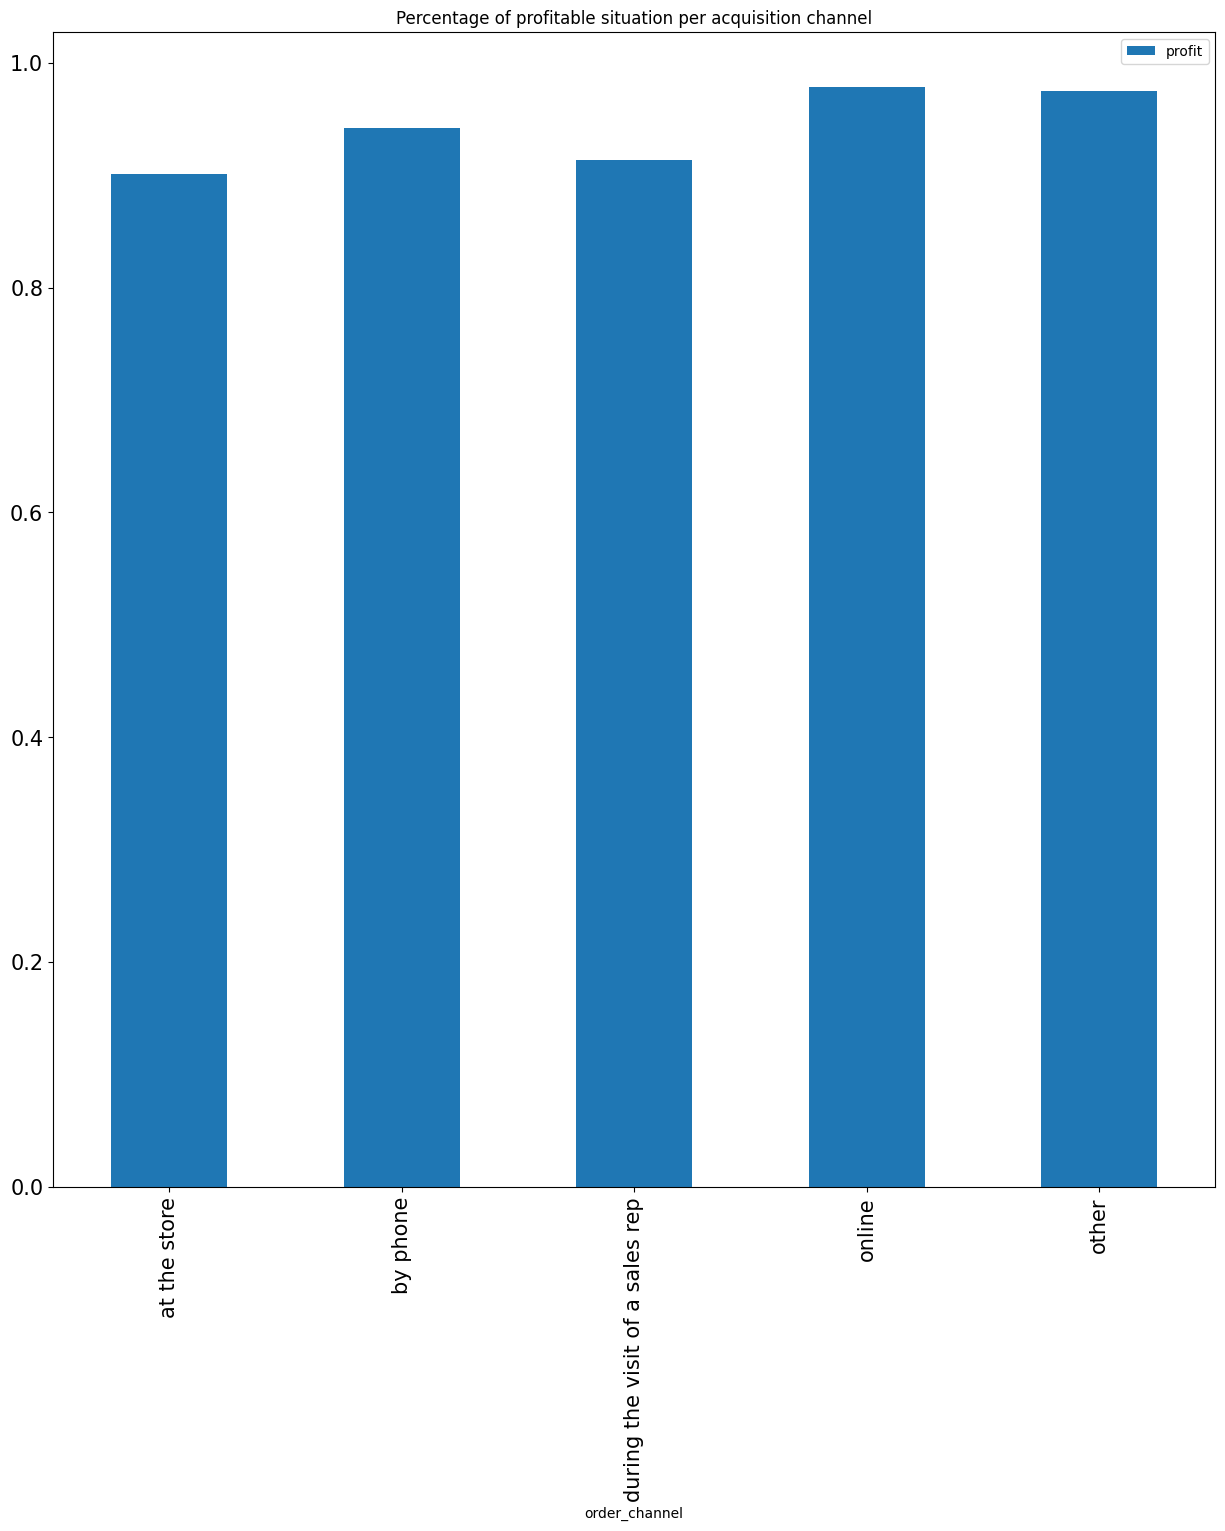

In [7]:
df_transaction["profit"] = df_transaction["profit"].apply(lambda x: 1 if x=="profitable" else 0)
pd.DataFrame(df_transaction.groupby("order_channel").profit.mean()).plot(kind="bar",title="Percentage of profitable situation per acquisition channel",fontsize=15,figsize=(15,15))
plt.show();

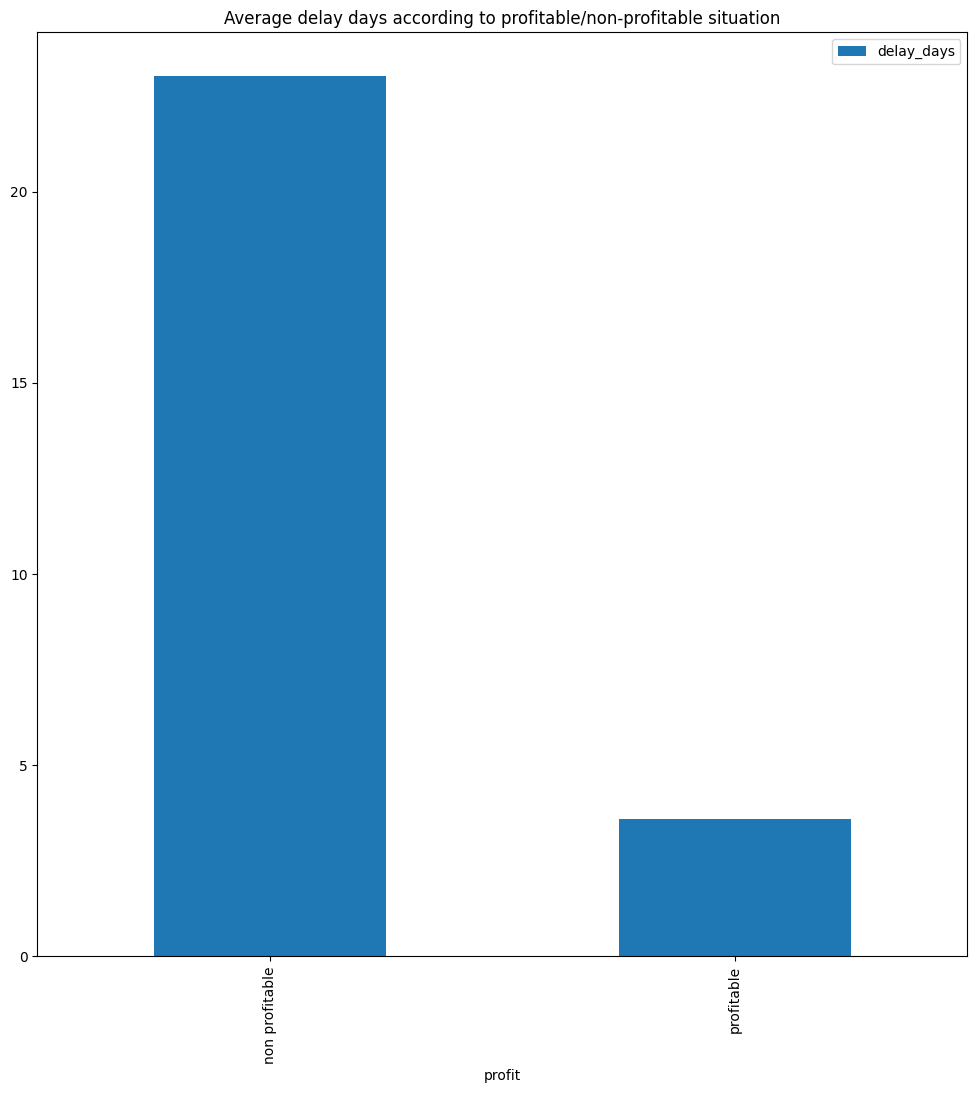

In [8]:
df_transaction["delay_days"] = pd.to_datetime(df_transaction["date_invoice"]) -  pd.to_datetime(df_transaction["date_order"])
df_transaction["profit"] = df_transaction["profit"].apply(lambda x: "profitable" if x==1 else "non profitable")
df_transaction["delay_days"] = df_transaction["delay_days"].dt.days
pd.DataFrame(df_transaction.groupby("profit").delay_days.mean()).plot(kind="bar",figsize=(12,12),title="Average delay days according to profitable/non-profitable situation")
plt.show();

In [9]:
df_transaction_non_profitable = df_transaction[df_transaction.profit=="non profitable"]
df_transaction_profitable = df_transaction[df_transaction.profit=="profitable"]


df_transaction_non_profitable.product_id.value_counts()

2512504    32092
3000784     4419
1366829     4079
1075327     2808
1895362     2712
           ...  
97341          1
905129         1
3001743        1
2258122        1
512090         1
Name: product_id, Length: 53332, dtype: int64

In [10]:
df_transaction_profitable.product_id.value_counts()

1366829    41354
3000784    38233
1895362    37941
1390401    34252
738406     21584
           ...  
3102189        1
109554         1
706857         1
2127235        1
490712         1
Name: product_id, Length: 167145, dtype: int64

In [11]:
def remove_outliers(df, columns):
    for col in columns:
        standard_deviation = np.std(df[col])
        mean = df[col].mean()
        df = df[(df[col]-mean)<standard_deviation]
    return df

In [12]:
df_transaction_filtered = remove_outliers(df_transaction, ["sales_net","quantity","delay_days"])

df_kmeans = df_transaction.groupby("product_id").mean()
df_kmeans = remove_outliers(df_kmeans, ["sales_net","quantity","delay_days"])

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0,init="k-means++").fit(df_kmeans[["sales_net","quantity","delay_days"]])
df_kmeans.reset_index(inplace=True)

In [14]:
df_kmeans["labels"] = kmeans.labels_

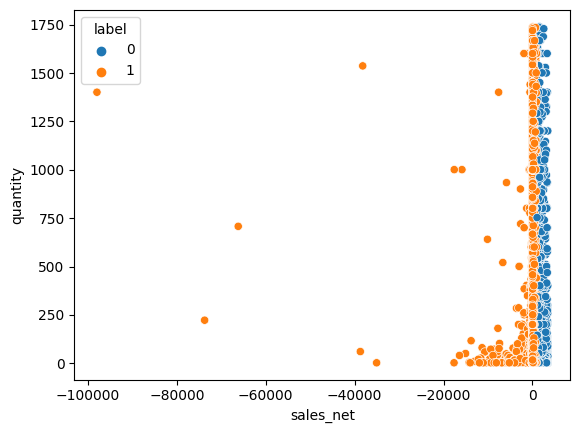

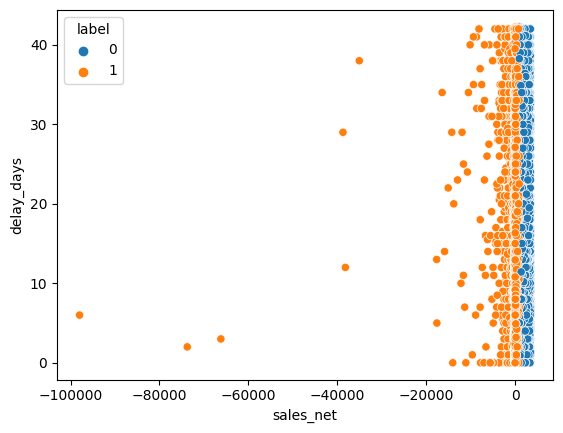

In [15]:
#filter rows of original data
df_kmeans["label"] = kmeans.labels_

sns.scatterplot(data=df_kmeans, x="sales_net", y="quantity", hue="label")
plt.show();

sns.scatterplot(data=df_kmeans, x="sales_net", y="delay_days", hue="label")
plt.show();

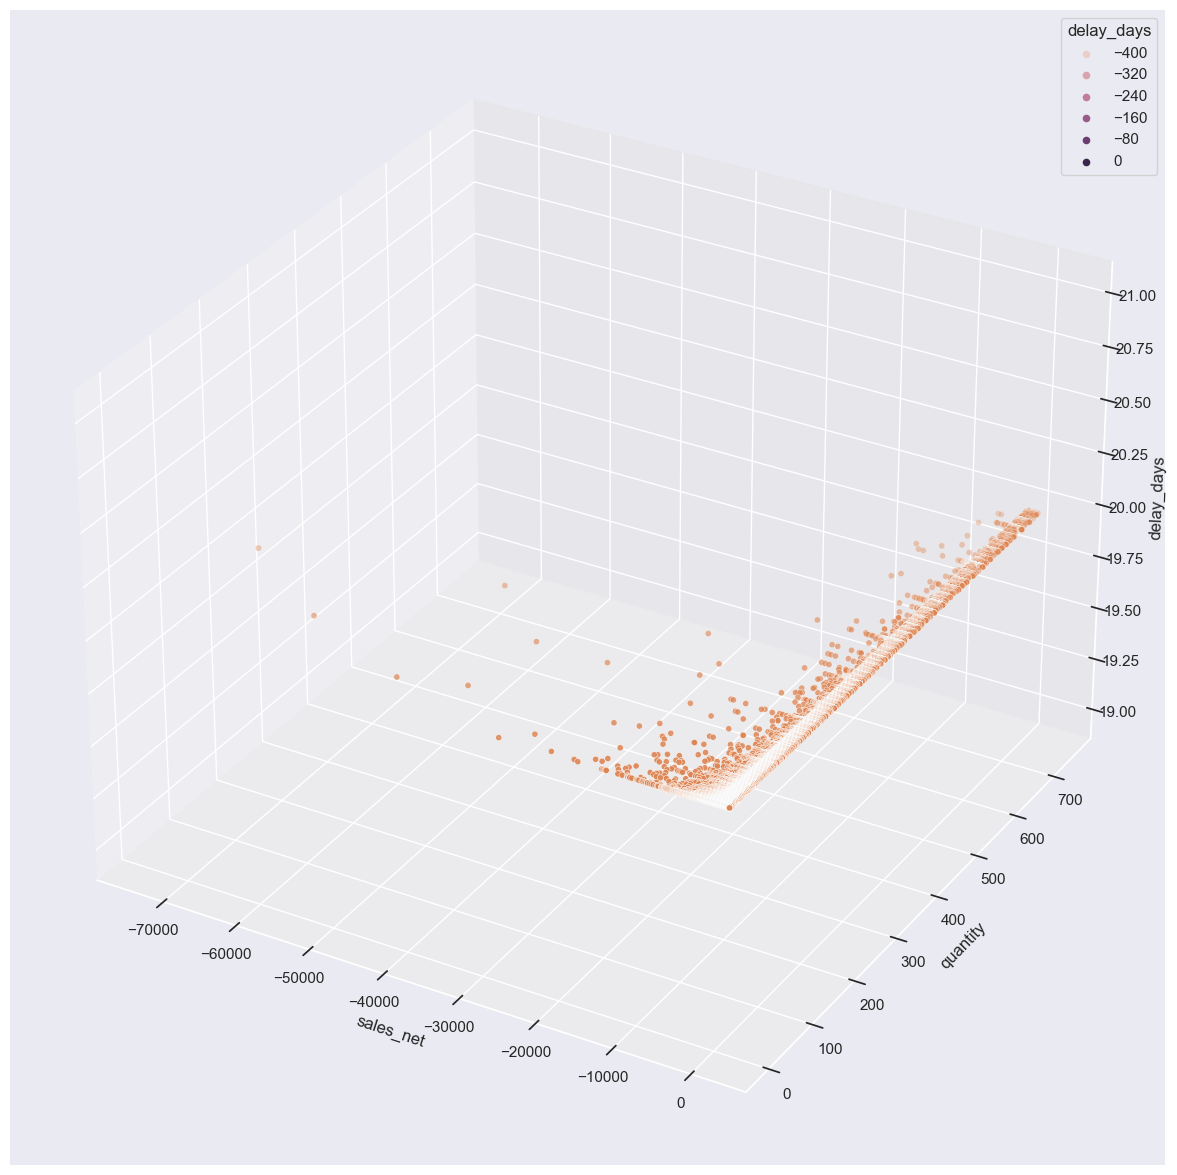

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings

warnings.filterwarnings("ignore")
sns.set(style = "darkgrid")

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("sales_net")
ax.set_ylabel("quantity")
ax.set_zlabel("delay_days")

sns.scatterplot(df_transaction_filtered['sales_net'], df_transaction_filtered['quantity'], df_transaction_filtered['delay_days'], hue="label")

plt.show();

## Churn Analysis

In [197]:
df_transaction = df_transaction.sort_values(by="date_order")

print("Il y a pour l'instant {} clients".format(df_transaction.client_id.nunique()))
print("En moyenne, un client commande {} fois en 2 ans soit {:.2f} fois par mois".format(
np.floor(pd.DataFrame(df_transaction.groupby("client_id").date_order.count()).sort_values(by="date_order",
ascending=False).date_order.mean()), pd.DataFrame(df_transaction.groupby("client_id").date_order.count()).sort_values(by="date_order",
ascending=False).date_order.mean()/24))

Il y a pour l'instant 134565 clients
En moyenne, un client commande 37.0 fois en 2 ans soit 1.55 fois par mois


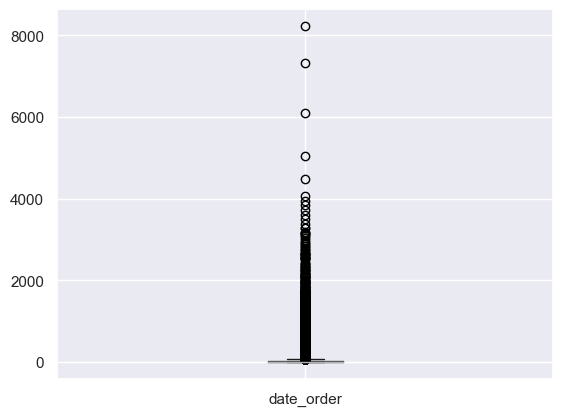

In [198]:
pd.DataFrame(df_transaction.groupby("client_id").date_order.count()).boxplot()
plt.show();

In [208]:
df_commande = pd.DataFrame(df_transaction.groupby("client_id").date_order.nunique()).sort_values(by="date_order",ascending=False).reset_index()

In [209]:
#On clusterise les clients en 3 catégories, les clients qui commandent rarement, occasionnellement et très 
#régulièrement 


kmeans = KMeans(n_clusters=3, random_state=42,init="k-means++").fit(np.array(df_commande.date_order).reshape(-1,1))
kmeans.labels_
df_commande["label"] = kmeans.labels_

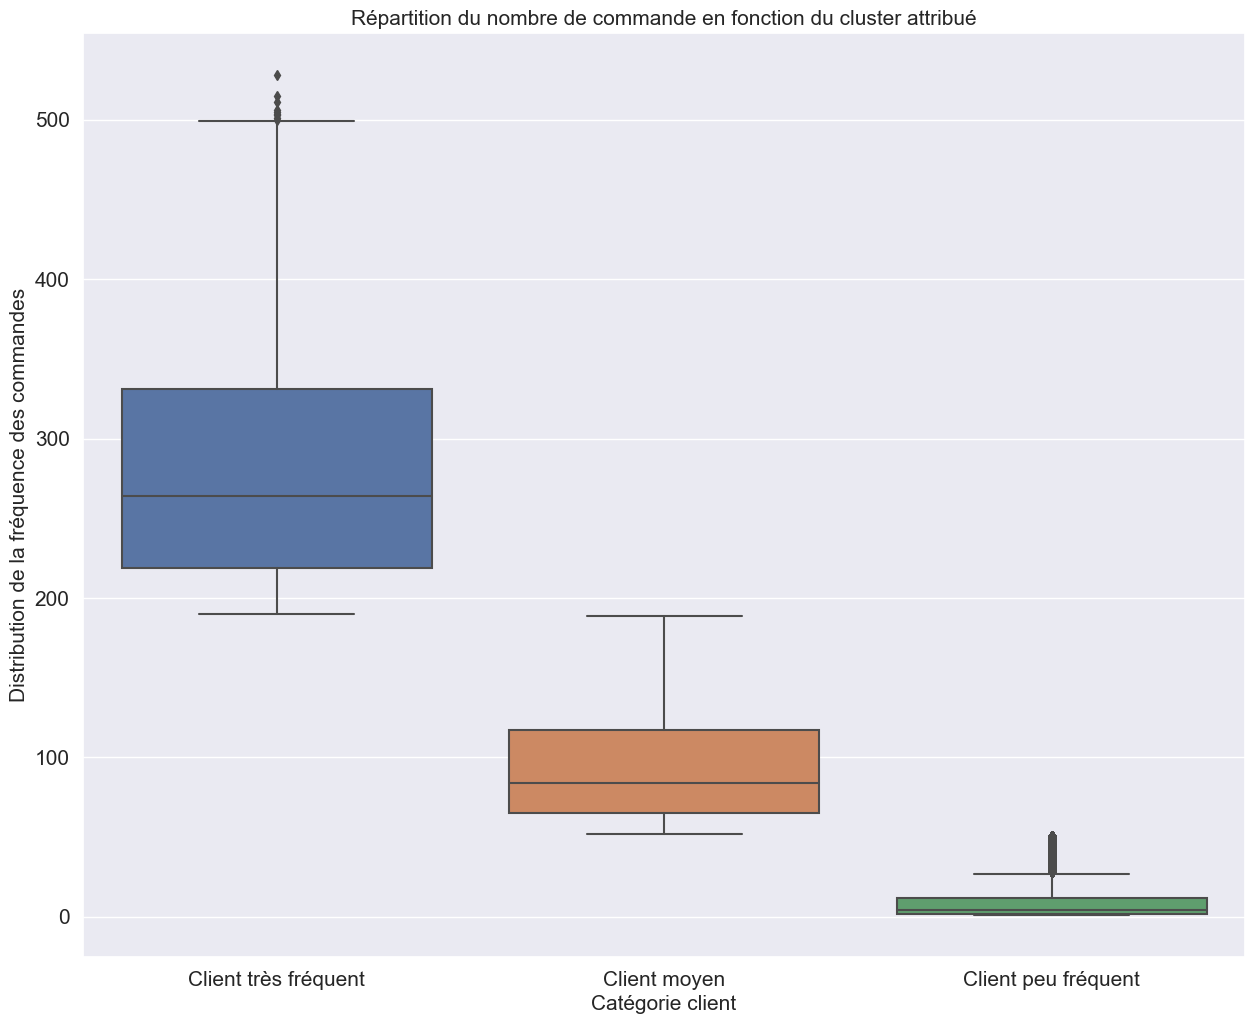

In [210]:
def clearer(x):
    if x==0:
        return "Client moyen"
    elif x==1:
        return "Client peu fréquent"
    else:
        return "Client très fréquent"

df_commande["label"] = df_commande["label"].apply(lambda x: clearer(x))

plt.figure(figsize=(15, 12))
ax = sns.boxplot(x="label", y="date_order", data=df_commande)
ax.set_xlabel("Catégorie client",fontsize=15)
ax.set_ylabel("Distribution de la fréquence des commandes",fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_title("Répartition du nombre de commande en fonction du cluster attribué",fontsize=15)
plt.show();

In [22]:
very_regular_clients = df_commande[df_commande.label==2].client_id.values
normal_clients = df_commande[df_commande.label==1].client_id.values
low_buyer_clients =  df_commande[df_commande.label==0].client_id.values

In [23]:
df_churn = df_transaction.groupby("client_id").agg({'date_order': ['min', 'max','count']})["date_order"]
df_churn = df_churn[df_churn["count"]>1]
df_churn["average_order"] = (df_churn["max"] - df_churn["min"])/df_churn["count"]
df_churn = df_churn.merge(df_commande.reset_index().drop(["index","date_order"],axis=1),on="client_id",how="left")

In [24]:
df_churn.groupby("label").average_order.mean()

label
client moyen           46 days 22:37:28.299385660
client peu fréquent     5 days 11:55:20.506353740
client très régulier    1 days 07:16:24.227463264
Name: average_order, dtype: timedelta64[ns]

In [25]:
df_churn.label.value_counts()

client moyen            98310
client peu fréquent     11957
client très régulier     2323
Name: label, dtype: int64

In [26]:
df_churn

,client_id,min,max,count,average_order,label
0,6,2018-11-20,2019-02-12,2,42 days 00:00:00,client moyen
1,7,2018-07-16,2018-12-24,2,80 days 12:00:00,client moyen
2,14,2017-09-25,2019-09-20,1059,0 days 16:25:50.141643059,client très régulier
3,18,2017-09-29,2019-09-12,165,4 days 07:42:32.727272727,client peu fréquent
4,37,2017-12-06,2019-04-23,5,100 days 14:24:00,client moyen
...,...,...,...,...,...,...
112585,2274398,2018-03-16,2019-08-01,4,125 days 18:00:00,client moyen
112586,2274410,2017-11-01,2019-09-12,40,17 days 00:00:00,client moyen
112587,2274440,2018-07-19,2019-09-12,6,70 days 00:00:00,client moyen
112588,2274479,2017-10-30,2019-02-27,2,242 days 12:00:00,client moyen


In [37]:
df_test = df_transaction[df_transaction.client_id==14].drop_duplicates(subset="date_order")
df_test.date_order.shift()

948618            NaT
171359     2017-09-25
3027341    2017-09-26
1509113    2017-09-27
599660     2017-09-29
              ...    
62379690   2019-09-09
62993591   2019-09-10
62702235   2019-09-12
62971538   2019-09-13
62907233   2019-09-18
Name: date_order, Length: 377, dtype: datetime64[ns]

In [41]:
np.mean(df_test.date_order - df_test.date_order.shift()) 

Timedelta('1 days 22:16:35.744680851')

In [48]:
#On caclule, pour chacun des 3 clusters, la moyenne et l'écart-type de l'écart entre 2 commandes

df_tres_regulier = df_transaction[df_transaction.client_id.isin(df_churn[df_churn.label=="client très régulier"].client_id)].sort_values(by="client_id")
moyenne_reguliers = np.mean(df_tres_regulier.date_order - df_tres_regulier.date_order.shift())
ecart_type_reguliers = np.std(df_tres_regulier.date_order - df_tres_regulier.date_order.shift())

In [50]:
ecart_type_reguliers

Timedelta('294 days 04:00:37.822882080')

In [51]:
np.mean(df_tres_regulier.date_order.shift() - df_tres_regulier.date_order)

Timedelta('0 days 00:00:20.029217576')

In [65]:
df_transaction_churn = df_transaction.drop_duplicates(subset=["client_id", "date_order"])
df_transaction_churn["date_order_shift"] = df_transaction_churn.date_order.shift()
df_transaction_churn.dropna(inplace=True)

In [69]:
seen_clients = []
def get_values_shift(x):
    if x in seen_clients:
        pass
    else:
        seen_clients.append(x)
        return df_transaction_churn[df_transaction_churn.client_id==x].sort_values(by="date_order").date_order_shift.values.tolist()

def get_values(x):
    return df_transaction_churn[df_transaction_churn.client_id==x].sort_values(by="date_order").date_order.values.tolist()

In [70]:
from tqdm import tqdm
tqdm.pandas()

df_transaction_churn["liste_shift"] = df_transaction_churn["client_id"].progress_apply(get_values_shift)
df_transaction_churn.to_csv("df_transaction_churn.csv",index=False)

100%|██████████| 2864779/2864779 [33:16<00:00, 1434.85it/s]


In [74]:
df_transaction_churn = df_transaction_churn[df_transaction_churn.liste_shift.notnull()]

In [183]:
df_transaction_churn

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,profit,delay_days,date_order_shift,liste_shift,liste_difference,moyenne_order_day,standard_deviation_day
455305,2017-09-22,2017-10-20,686712,688261,-216.218400,3,online,4157,non profitable,28.0,2017-09-22,"[2017-09-22 02:00:00, 2017-10-09 02:00:00, 201...","[17, 1, 1, 5, 2, 9, 9, 8, 22, 14, 2, 6, 32, 2,...",17.250000,20.101651
107801,2017-09-23,2017-09-25,2319965,1826966,14.269200,3,online,4072,profitable,2.0,2017-09-22,"[2017-09-22 02:00:00, 2017-10-02 02:00:00, 201...","[10, 29, 33, 39, 26, 6, 27, 135, 7, 3, 61, 54,...",35.700000,34.753561
514032,2017-09-23,2017-09-25,1600867,168615,212.906400,3,online,5344,profitable,2.0,2017-09-23,"[2017-09-23 02:00:00, 2017-10-02 02:00:00, 201...","[9, 2, 1, 6, 5, 2, 12, 7, 6, 1, 6, 1, 1, 2, 11...",5.165468,4.828866
172215,2017-09-23,2017-09-25,1026828,1430039,35.245200,3,online,1888,profitable,2.0,2017-09-23,"[2017-09-23 02:00:00, 2017-09-25 02:00:00, 201...","[2, 3, 4, 3, 12, 8, 6, 1, 4, 1, 6, 4, 17, 1, 3...",7.771739,8.627690
55358,2017-09-23,2017-09-25,1149737,668461,102.423600,3,online,278,profitable,2.0,2017-09-23,"[2017-09-23 02:00:00, 2017-09-25 02:00:00, 201...","[2, 2, 7, 1, 4, 2, 1, 7, 4, 17, 3, 7, 9, 5, 1,...",5.201439,5.213679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62824399,2019-09-20,2019-09-20,568379,1827045,91.549200,3,at the store,9110,profitable,0.0,2019-09-20,[2019-09-20 02:00:00],[],NaN,NaN
62831051,2019-09-20,2019-09-20,1838154,271290,380.128667,13,online,2744,profitable,0.0,2019-09-20,[2019-09-20 02:00:00],[],NaN,NaN
62856298,2019-09-20,2019-09-20,17844,951001,314.253600,3,at the store,6465,profitable,0.0,2019-09-20,[2019-09-20 02:00:00],[],NaN,NaN
62974082,2019-09-20,2019-09-20,3186027,1985195,822.038400,3,at the store,409,profitable,0.0,2019-09-20,[2019-09-20 02:00:00],[],NaN,NaN


In [118]:
import datetime
def get_date(liste):
    new_list = []
    for item in liste:
        new_item = int(str(item)[:10])
        new_list.append(datetime.datetime.fromtimestamp(new_item))
    return new_list

In [120]:
df_transaction_churn["liste_shift"] = df_transaction_churn["liste_shift"].progress_apply(get_date)

100%|██████████| 134565/134565 [00:03<00:00, 34572.39it/s]


In [130]:
(df_transaction_churn["liste_shift"][455305][1] - df_transaction_churn["liste_shift"][455305][0]).days

17

In [134]:
def get_difference(liste):
    new_list = []
    if len(liste)<=1:
        pass
    else:
        for i in range(1,len(liste)):
            new_list.append((liste[i]-liste[i-1]).days)
    return new_list
df_transaction_churn["liste_difference"] = df_transaction_churn["liste_shift"].apply(get_difference)

In [138]:
df_transaction_churn["moyenne_order_day"] = df_transaction_churn["liste_difference"].apply(lambda x: np.mean(x))
df_transaction_churn["standard_deviation_day"] = df_transaction_churn["liste_difference"].apply(lambda x: np.std(x))

In [141]:
df_transaction = df_transaction.merge(df_transaction_churn[["client_id","moyenne_order_day","standard_deviation_day"]],on="client_id",how="left")

In [144]:
df_transaction = df_transaction.merge(df_churn[["client_id","label"]],on="client_id",how="left")

In [149]:
df_transaction["jours_limites_churn"] = df_transaction["moyenne_order_day"] + 2*df_transaction["standard_deviation_day"]

In [162]:
df_max = pd.DataFrame(df_transaction.groupby("client_id",as_index=False).date_order.max()).rename(columns={"date_order": "last_order_date"})
df_transaction = df_transaction.merge(df_max,on="client_id",how="left")

AttributeError: 'DataFrameGroupBy' object has no attribute 'date_order'

In [163]:
pd.DataFrame(df_transaction.groupby("client_id",as_index=False).date_order.max())

AttributeError: 'DataFrameGroupBy' object has no attribute 'date_order'

In [169]:
df_transaction[df_transaction.client_id=="6"]

,date_order_x,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,profit,delay_days,moyenne_order_day,standard_deviation_day,label,jours_limites_churn,date_order_y


In [167]:
df_

,client_id,date_order
0,6,2019-02-12
1,7,2018-12-24
2,14,2019-09-20
3,18,2019-09-12
4,37,2019-04-23
...,...,...
134560,2274440,2019-09-12
134561,2274479,2019-02-27
134562,2274504,2017-11-02
134563,2274508,2017-10-18


In [171]:
df_transaction.rename(columns={"date_order_x": "date_order", "date_order_y":"last_order_date"},inplace=True)

In [176]:
df_transaction["churn_alert_date"] = df_transaction["last_order_date"] + datetime.timedelta(days=df_transaction.jours_limites_churn)

TypeError: unsupported type for timedelta days component: Series

In [182]:
df_transaction.to_csv('sauvegarde.csv',index=False)

In [185]:
df_transaction()
df_transaction.groupby("label").moyenne_order_day.mean()

label
client moyen            43.001950
client peu fréquent      7.141334
client très régulier     2.337436
Name: moyenne_order_day, dtype: float64

In [187]:
df_transaction.last_order_date.min()

Timestamp('2017-09-25 00:00:00')